In [4]:
from scripts import *

### Extract Symbol (i.e Spade/Heart etc...) from bboxed cards

<b> Test classifier accuracy on full dataset </b>

In [92]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_loader import DataLoader
from scripts.extract import get_color_pixels

folder = "./media/cropped_symb"

data = DataLoader()

images = []
for root, dirnames, filenames in os.walk(folder):
    for filename in filenames:
        round_, player, _ = filename.replace('r', ' ').replace('.', ' ').split()
        
        if root[-1] == '7':
            continue
        
        image = cv2.imread(os.path.join(root, filename))
        mask_red   = get_color_pixels(image, 'red')
        mask_black = get_color_pixels(image, 'black')
        image = mask_red if mask_red.sum() > mask_black.sum() else mask_black
        
        # adds connected components and take largest one minus background
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, 
                                                                                4 ,
                                                                                cv2.CV_32S)
        max_idx = np.argsort(stats[:,-1])[::-1][1]
        image = (labels == max_idx).astype(np.uint8) * 255
        
        label = data[int(root[-1]), int(round_)][1]['P' + player]
        label = label[1]
        
        images.append( {'game': root[-1], 'round': round_, 'player': player, 'image': image, 'label': label})
        
images = pd.DataFrame(images)
print(images)


    game round player                                              image label
0      1     9      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
1      1     5      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
2      1    10      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
3      1     7      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
4      1    13      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
..   ...   ...    ...                                                ...   ...
307    3     2      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
308    3     9      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
309    3    13      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
310    3    13      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
311    3     5      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D

[312 rows x 5 columns]


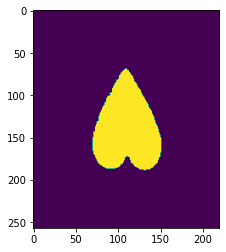

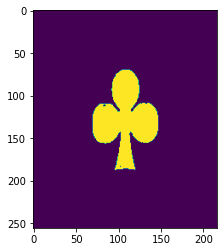

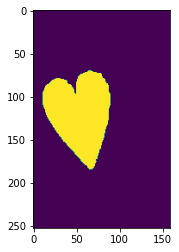

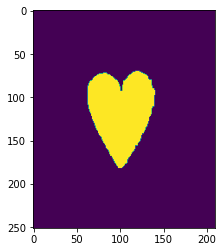

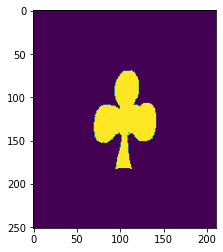

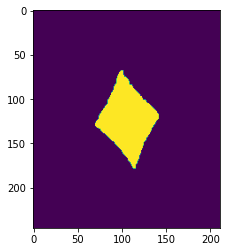

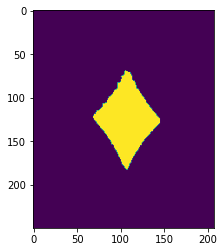

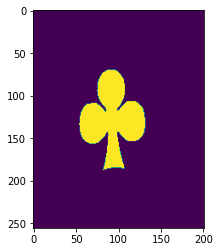

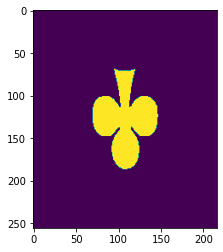

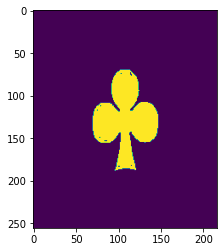

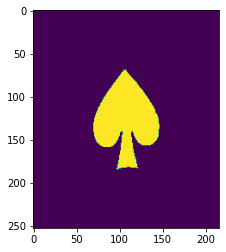

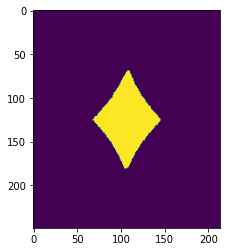

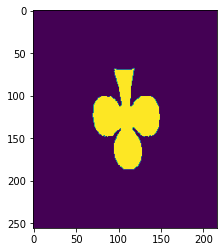

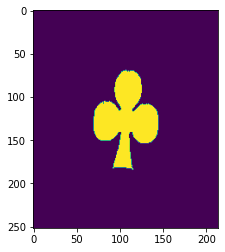

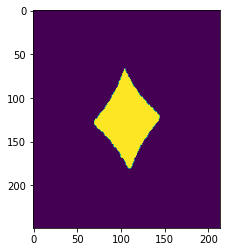

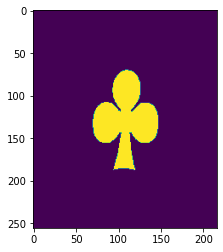

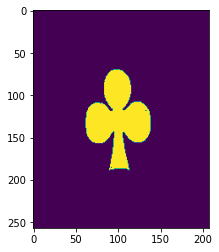

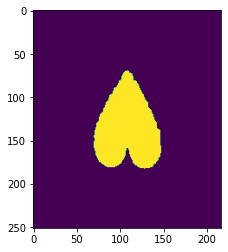

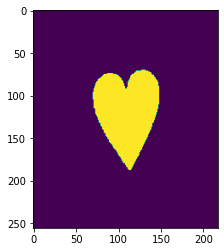

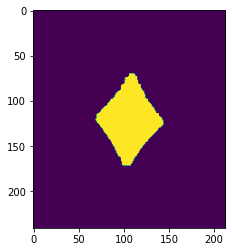

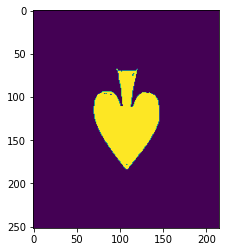

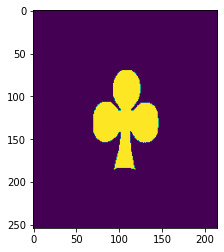

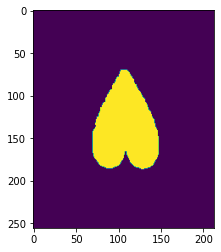

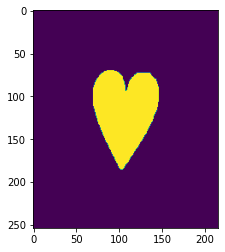

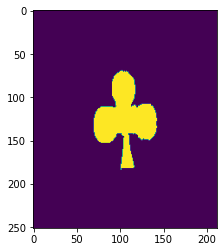

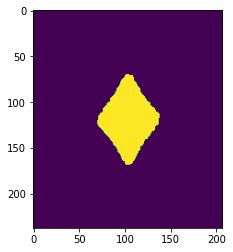

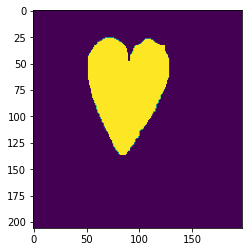

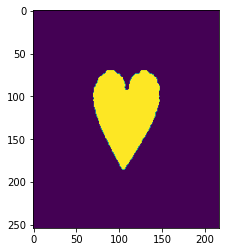

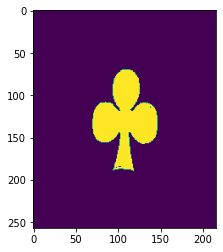

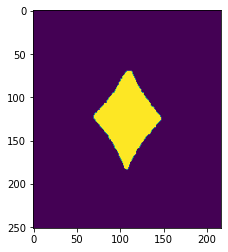

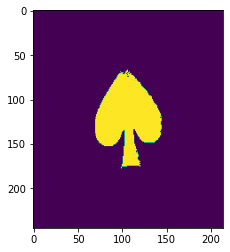

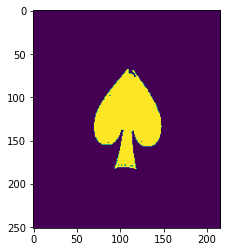

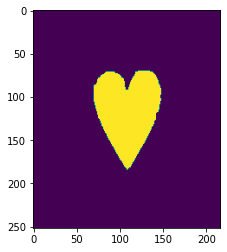

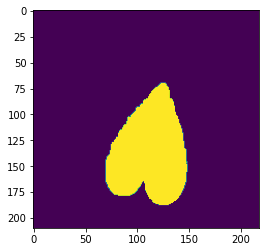

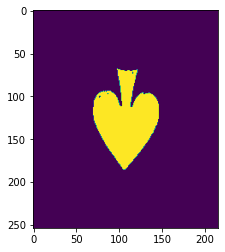

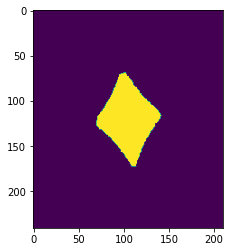

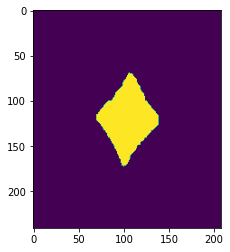

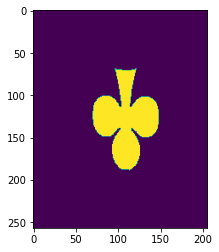

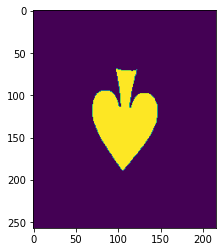

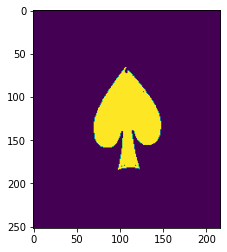

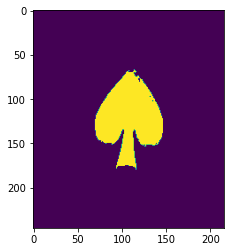

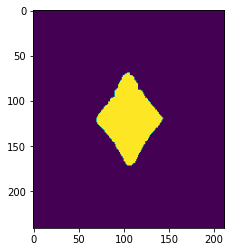

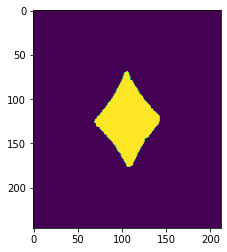

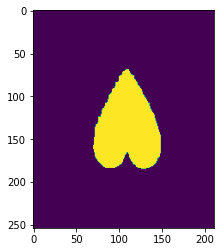

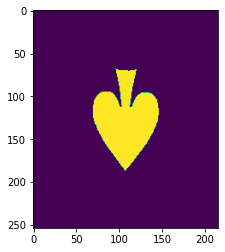

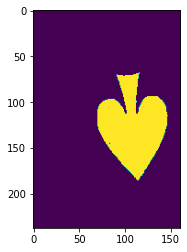

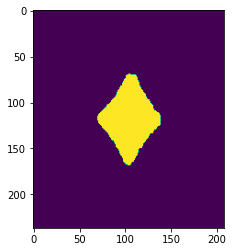

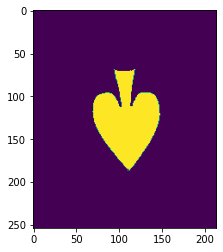

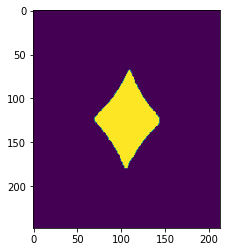

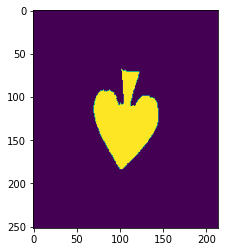

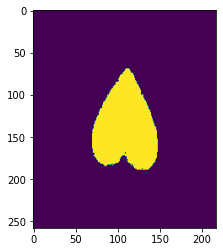

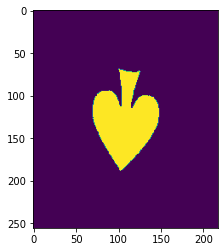

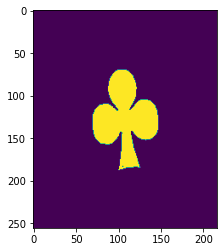

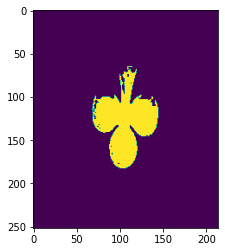

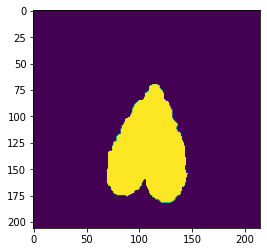

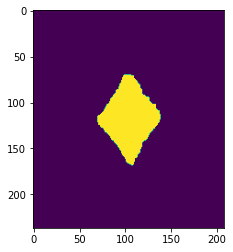

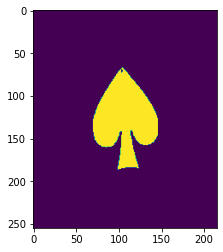

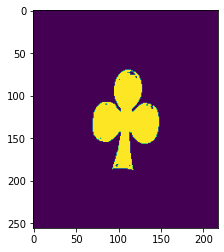

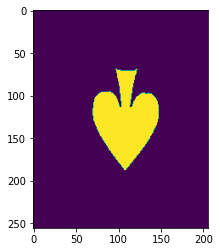

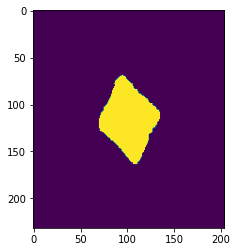

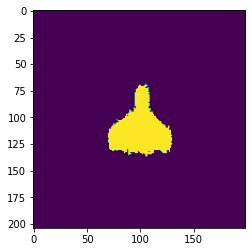

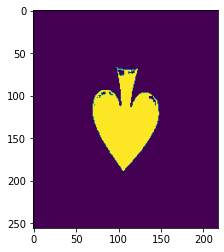

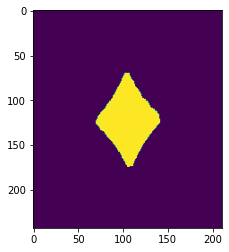

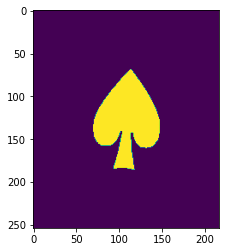

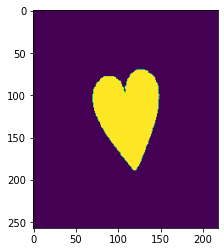

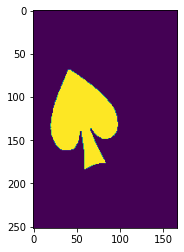

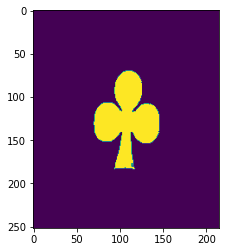

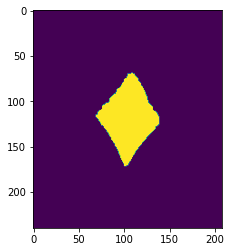

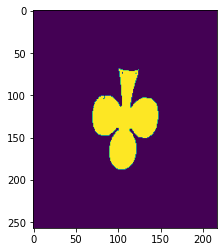

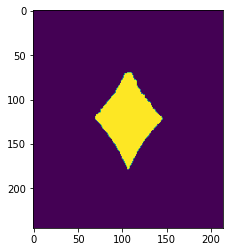

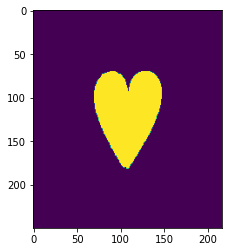

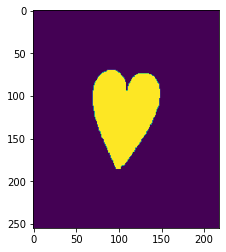

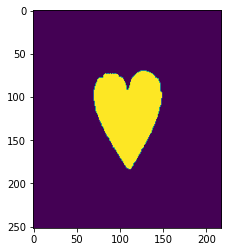

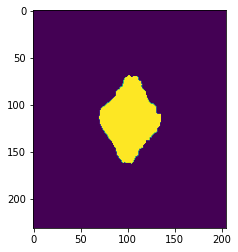

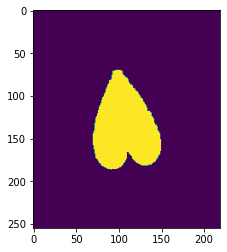

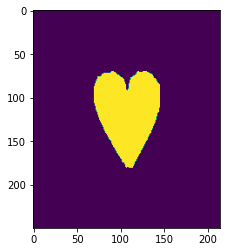

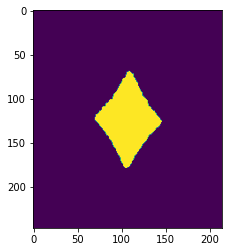

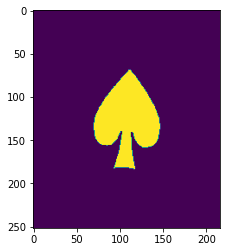

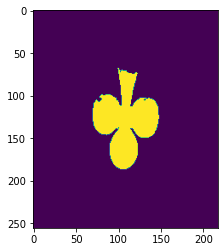

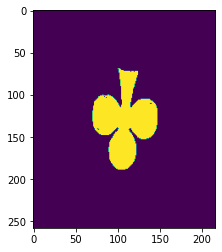

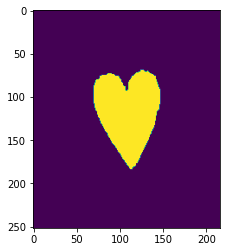

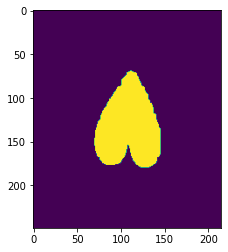

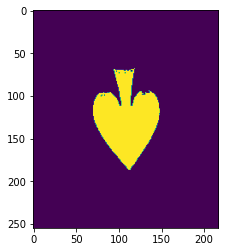

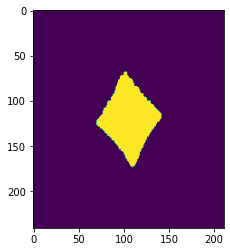

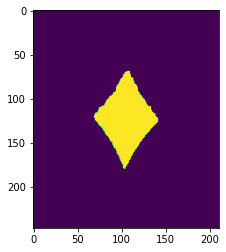

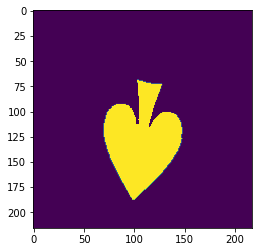

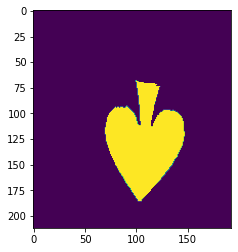

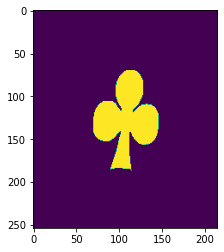

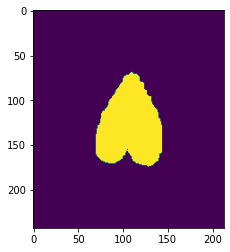

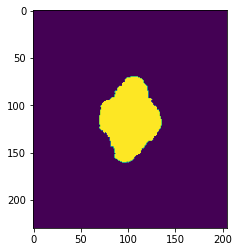

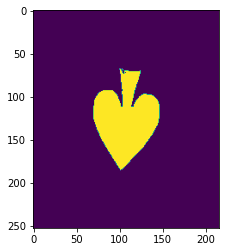

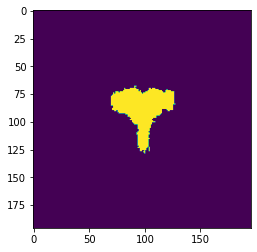

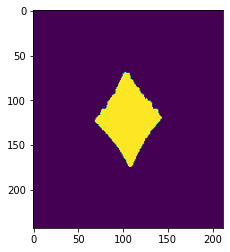

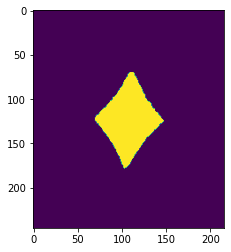

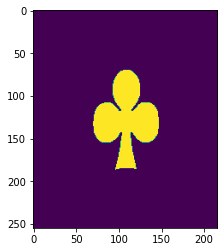

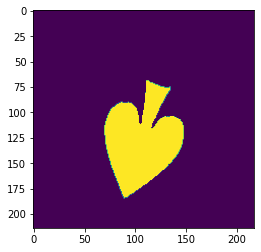

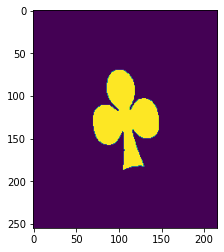

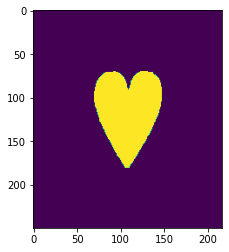

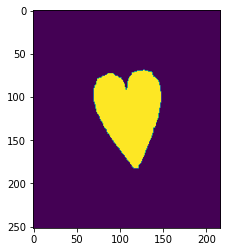

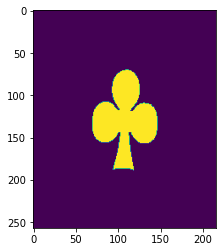

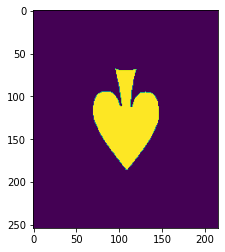

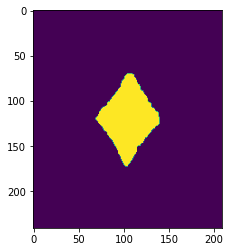

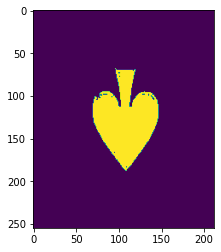

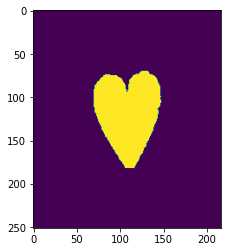

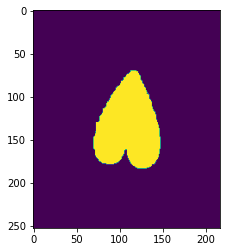

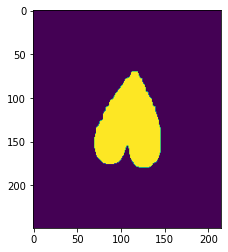

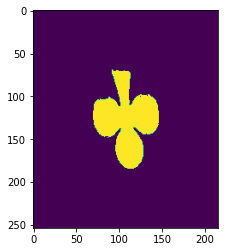

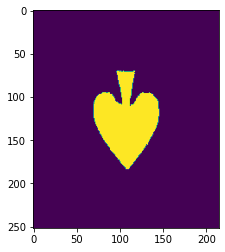

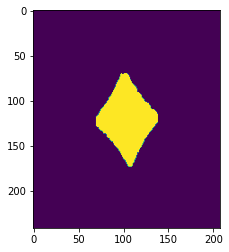

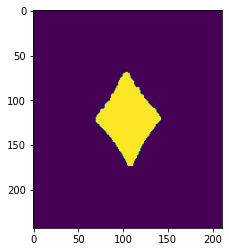

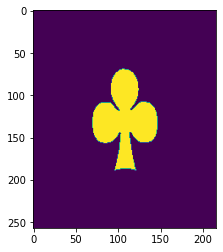

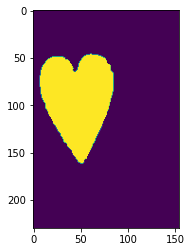

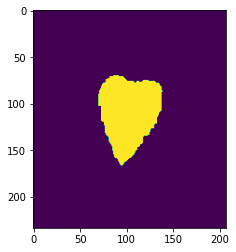

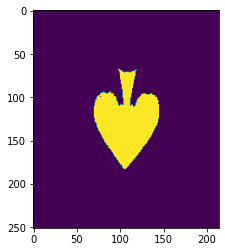

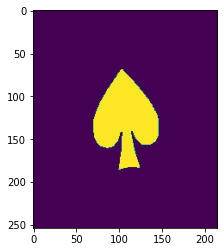

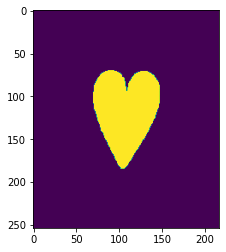

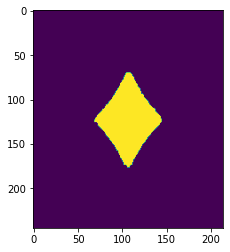

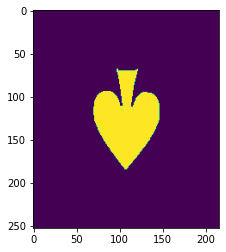

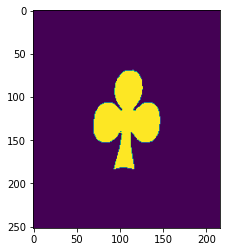

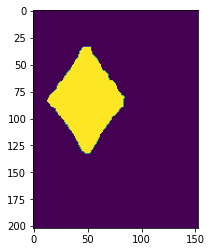

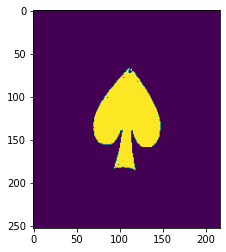

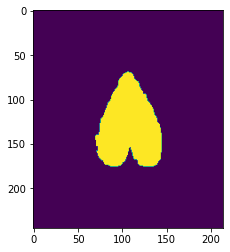

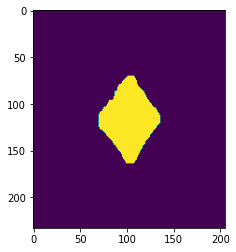

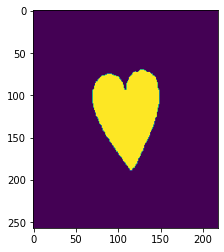

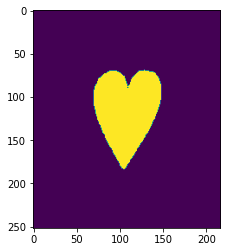

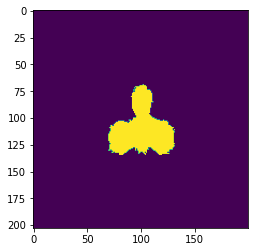

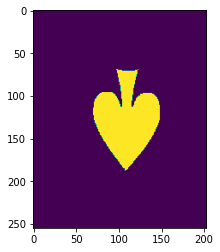

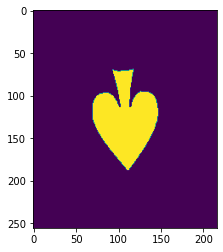

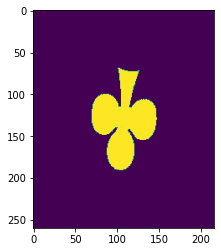

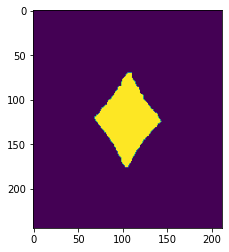

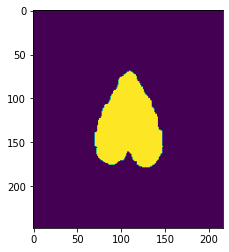

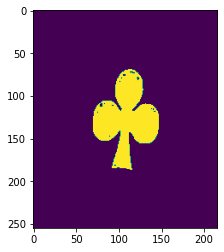

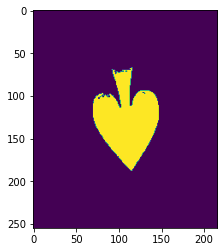

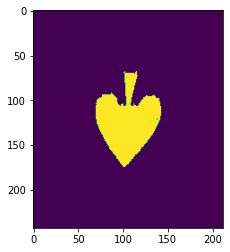

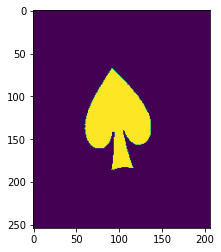

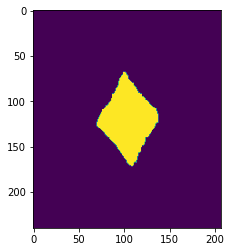

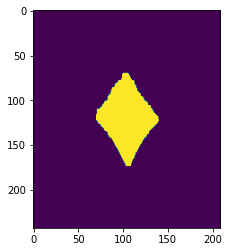

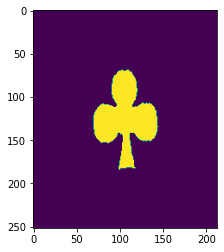

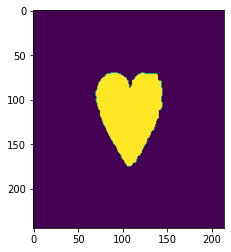

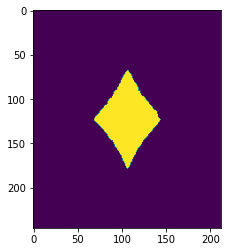

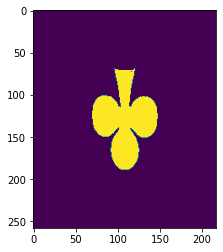

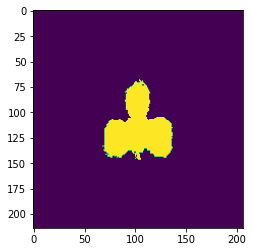

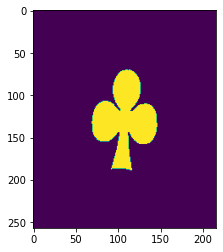

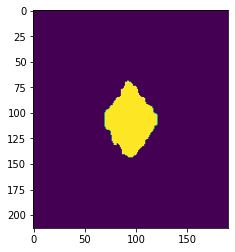

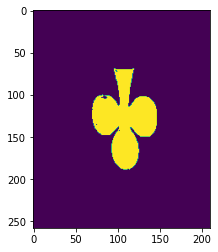

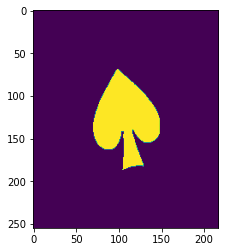

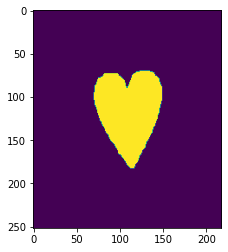

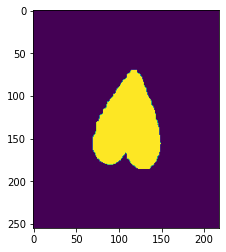

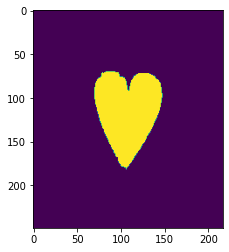

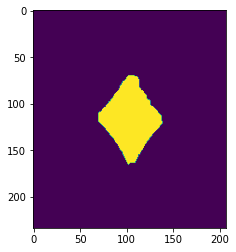

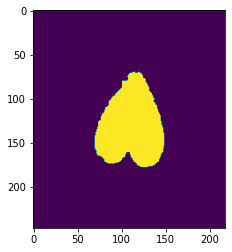

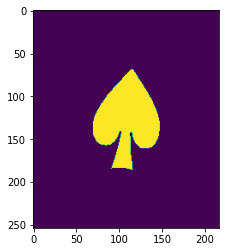

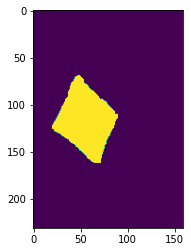

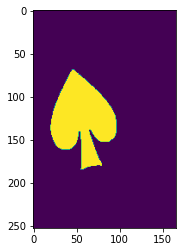

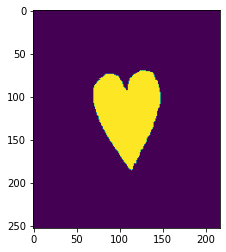

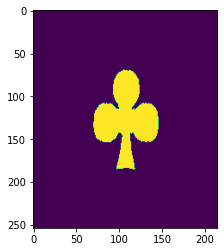

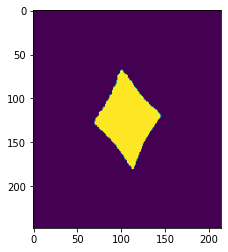

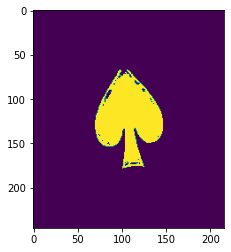

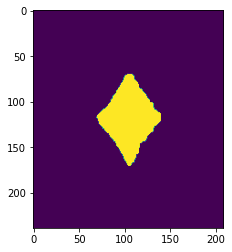

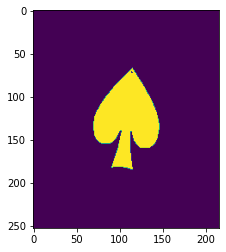

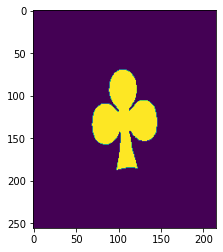

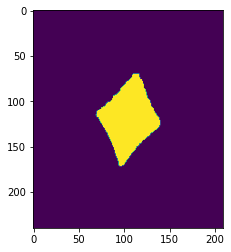

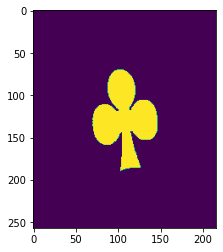

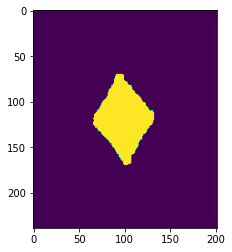

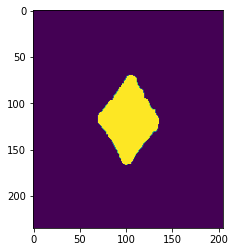

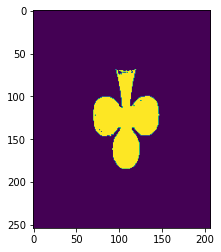

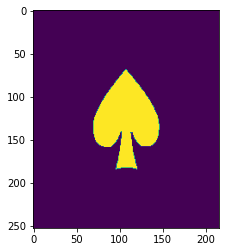

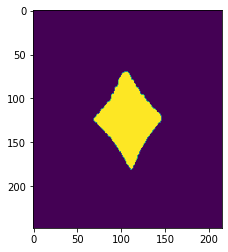

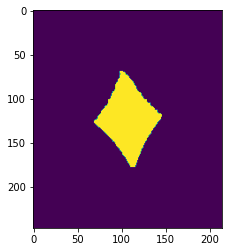

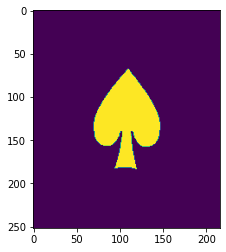

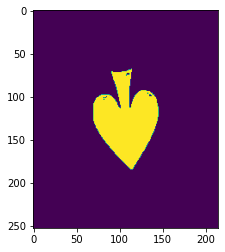

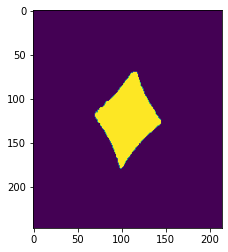

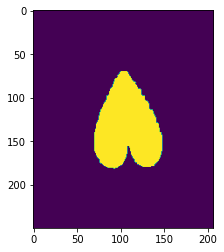

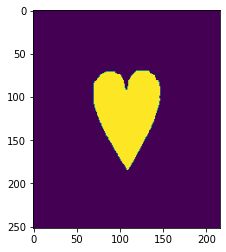

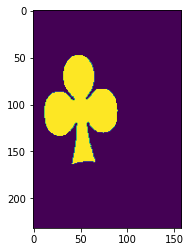

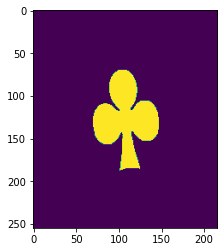

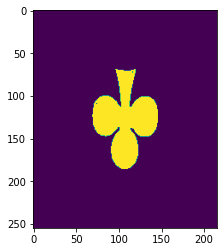

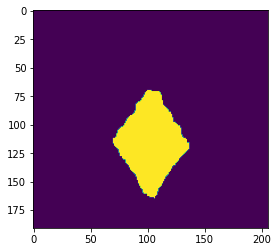

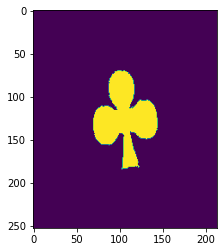

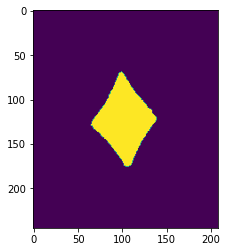

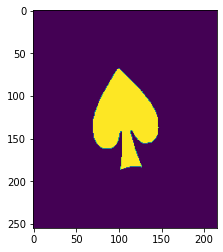

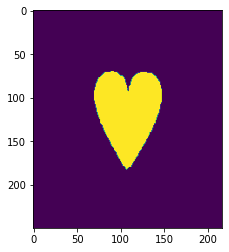

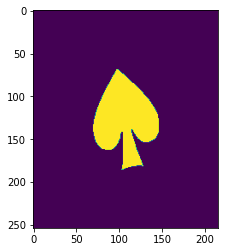

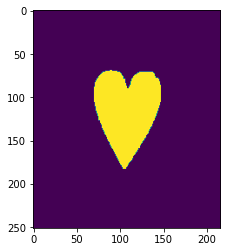

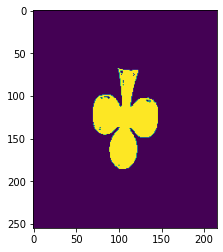

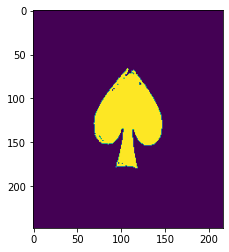

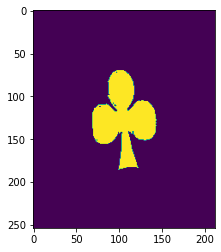

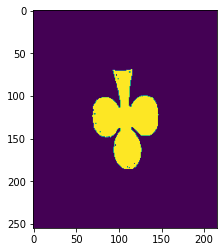

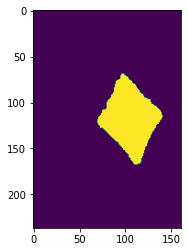

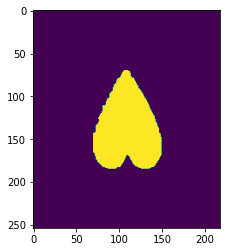

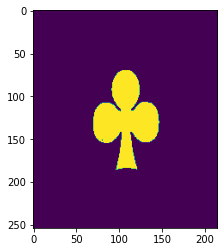

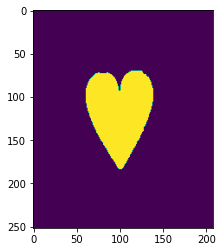

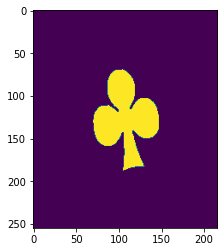

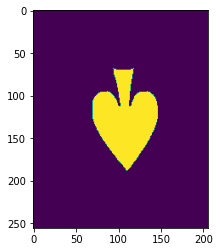

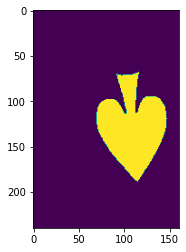

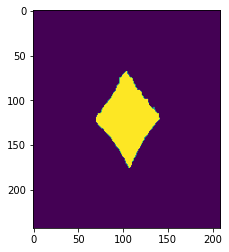

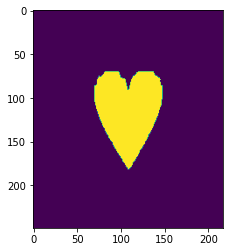

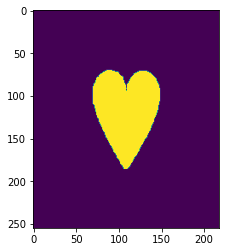

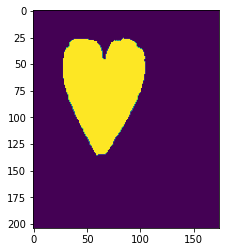

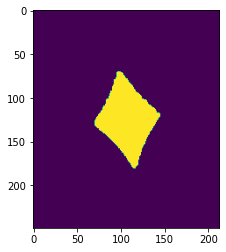

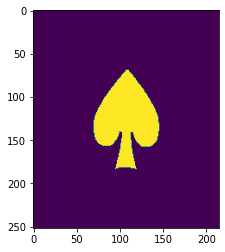

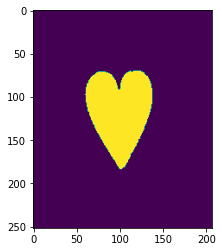

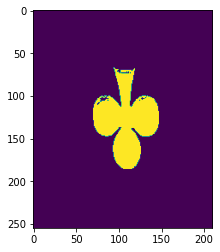

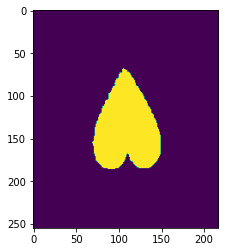

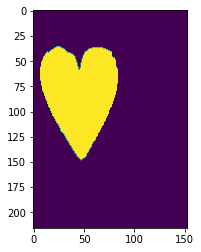

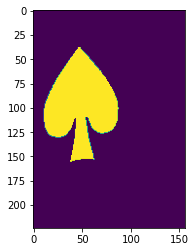

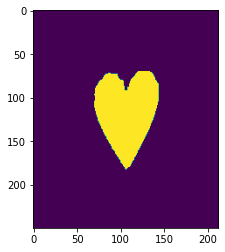

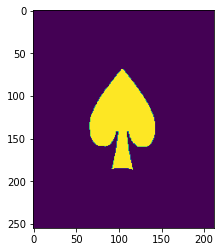

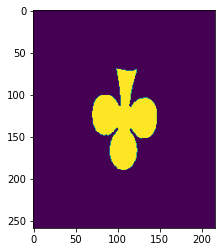

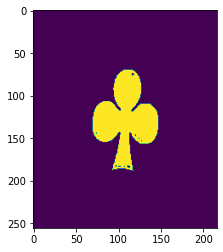

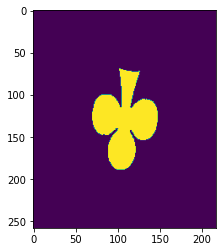

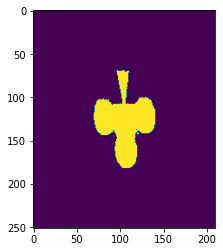

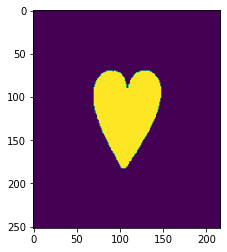

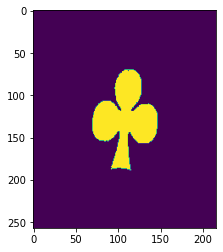

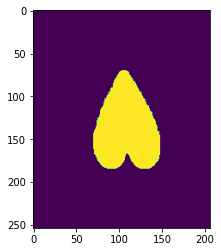

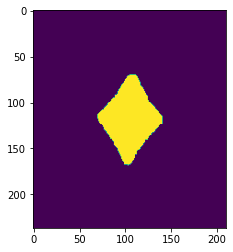

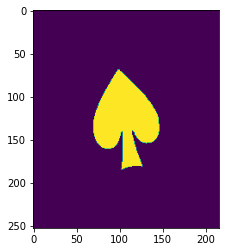

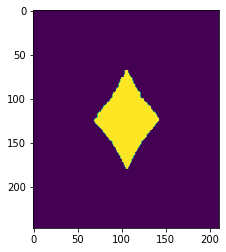

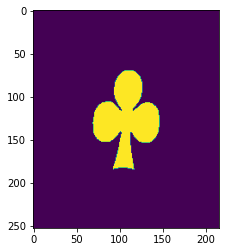

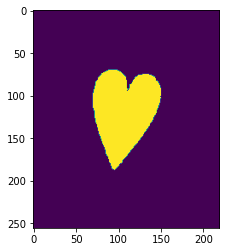

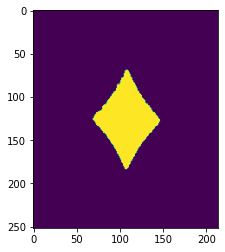

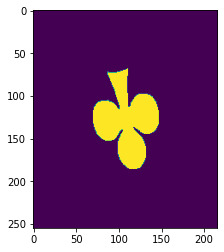

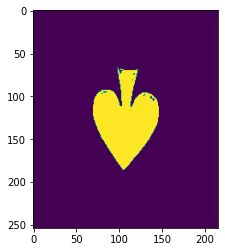

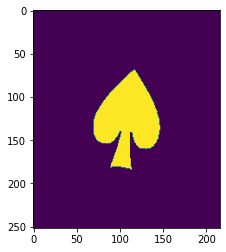

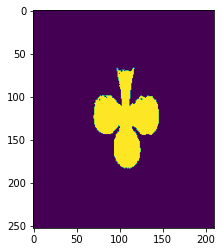

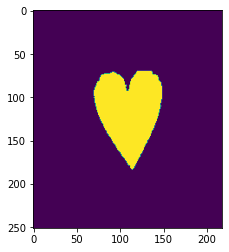

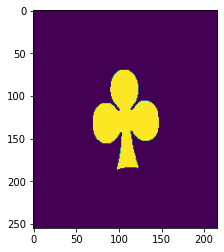

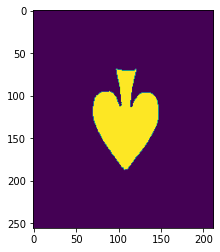

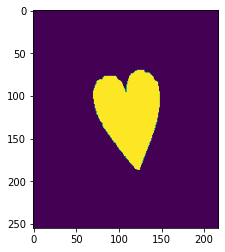

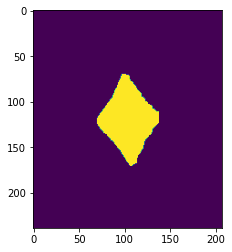

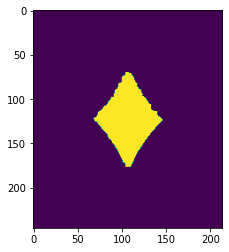

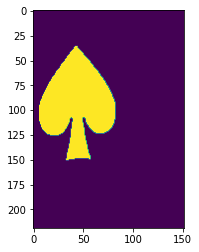

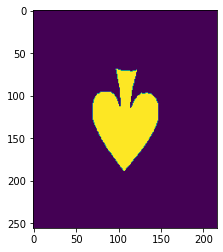

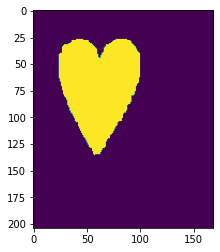

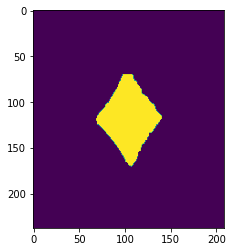

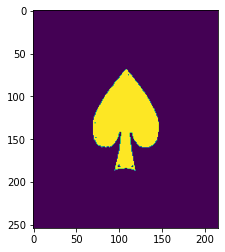

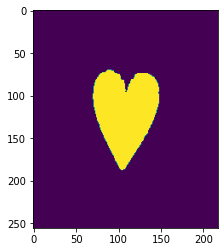

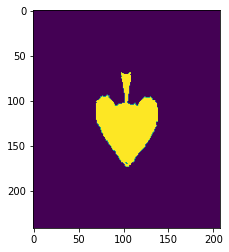

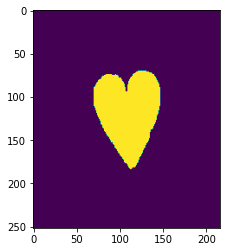

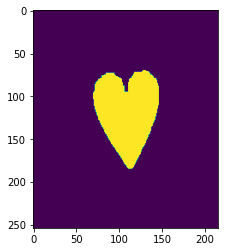

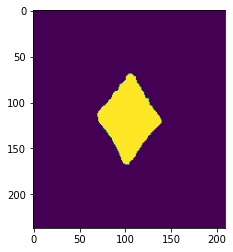

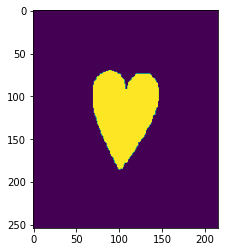

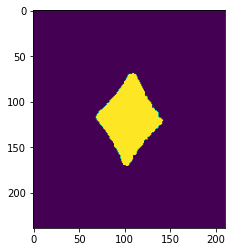

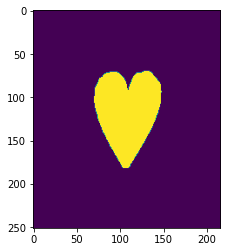

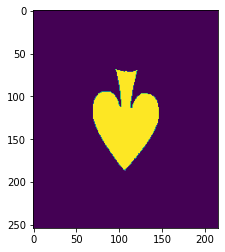

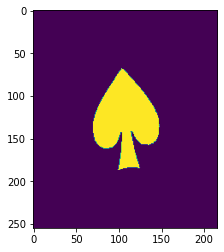

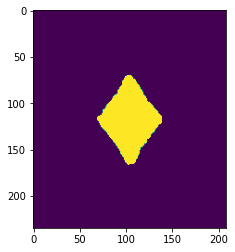

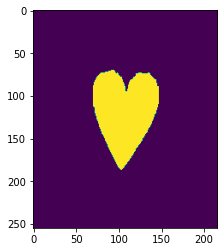

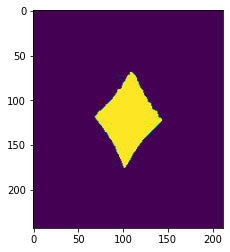

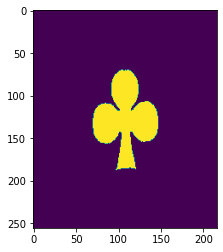

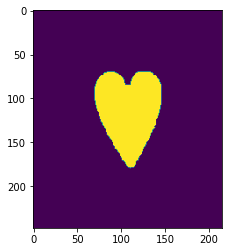

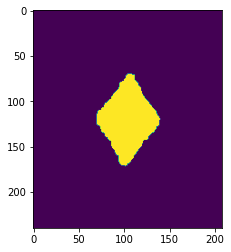

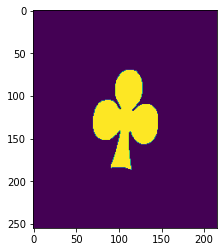

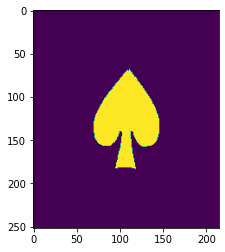

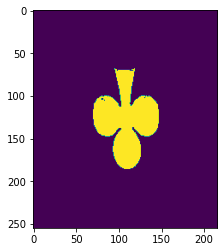

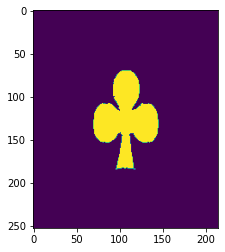

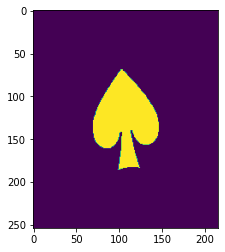

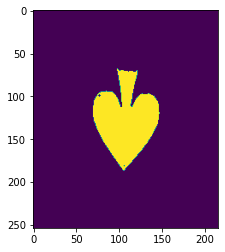

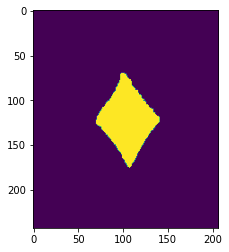

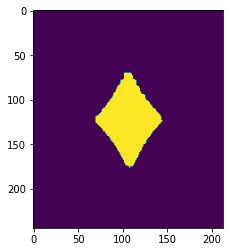

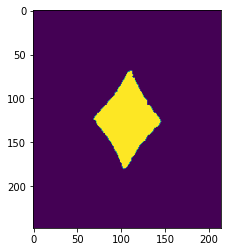

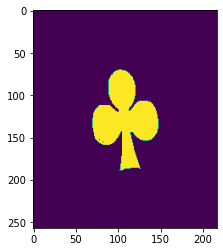

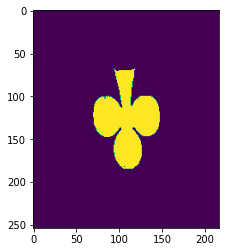

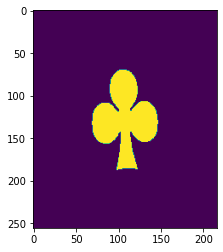

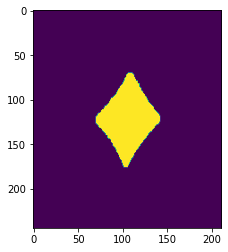

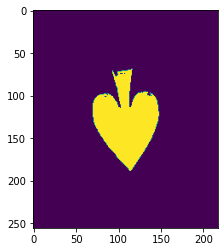

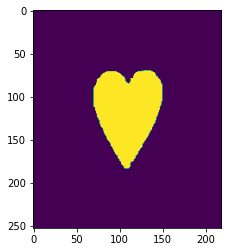

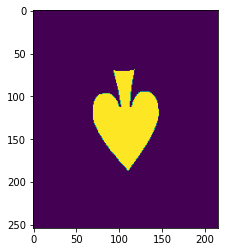

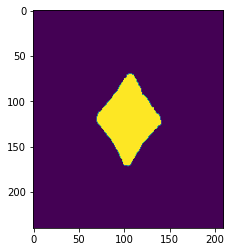

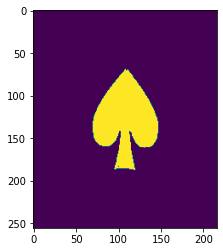

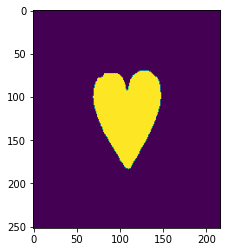

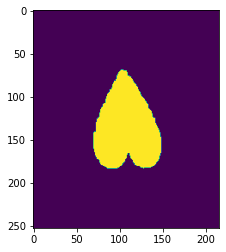

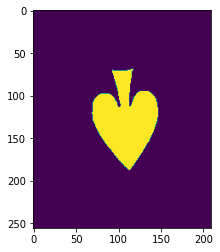

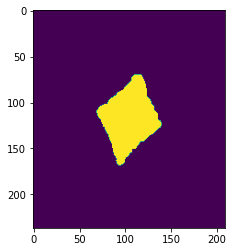

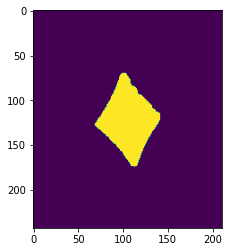

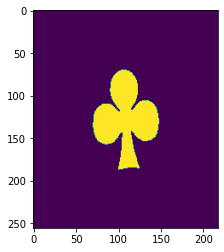

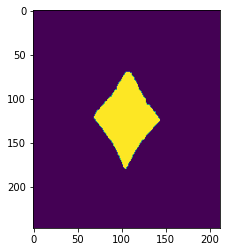

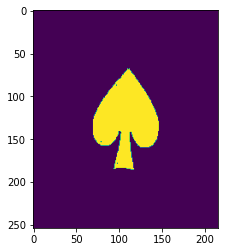

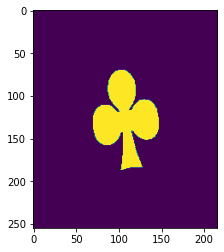

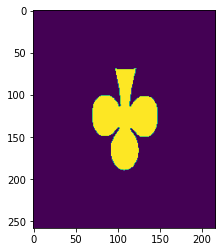

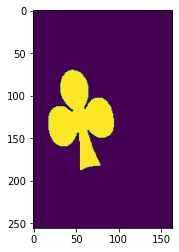

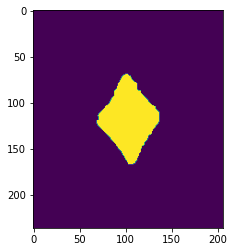

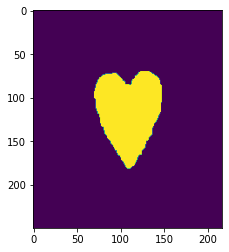

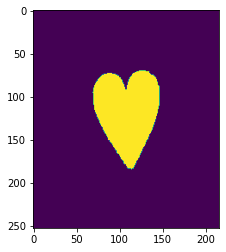

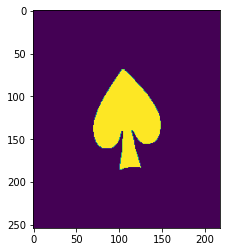

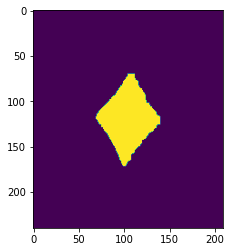

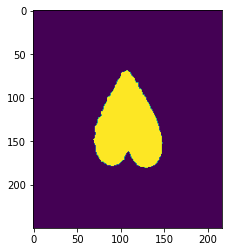

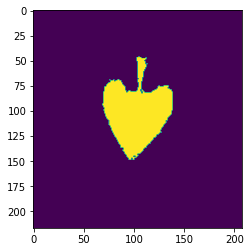

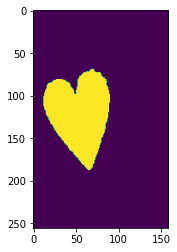

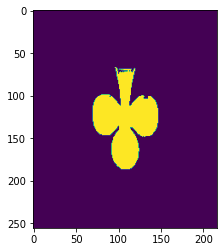

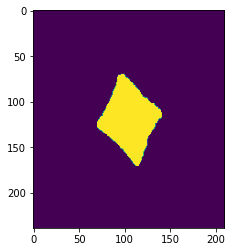

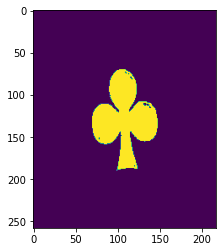

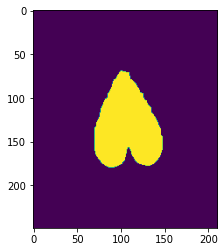

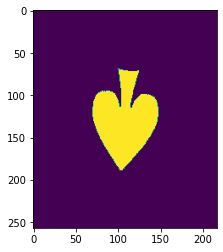

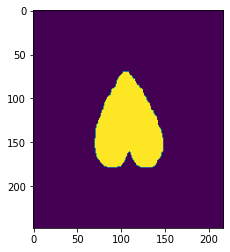

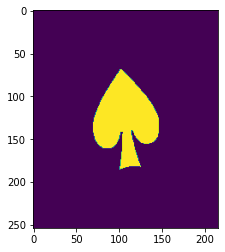

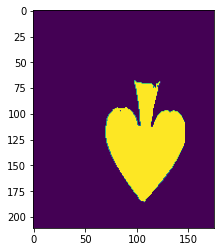

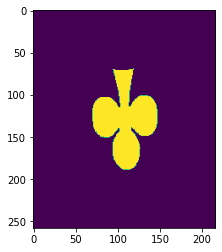

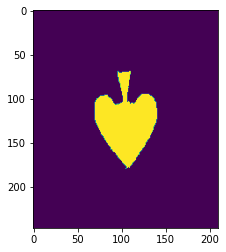

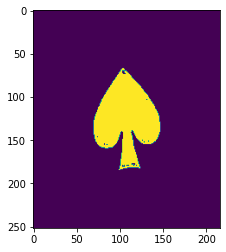

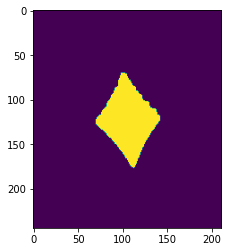

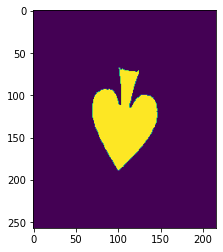

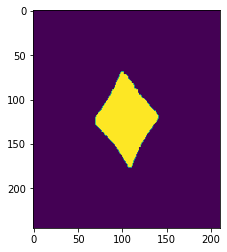

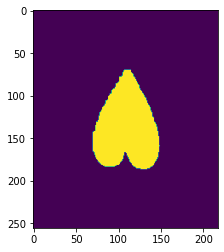

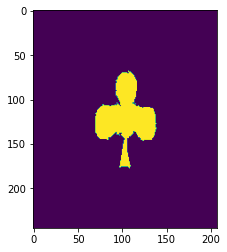

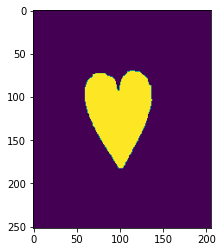

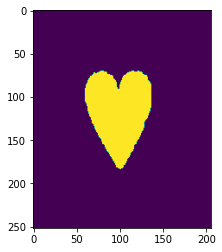

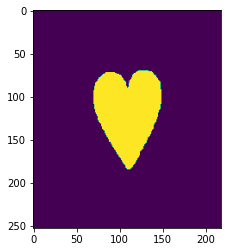

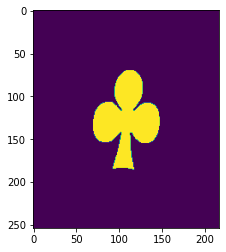

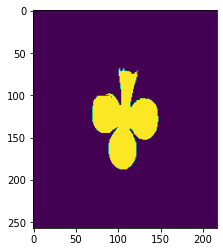

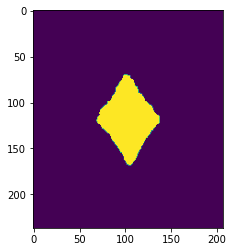

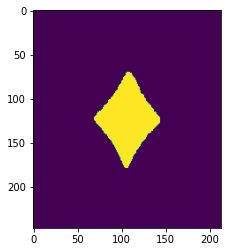

In [93]:
# verify the cleanliness of inputs images
for i in range(images['image'].shape[0]):
    plt.imshow(images['image'].iloc[i])
    plt.show()

In [6]:
def get_fourier_descriptor(image, n_coefficients_to_keep = 2):
    """
    Function returning a Fourier descriptor of image made by keeping the first n_coefficients_to_keep coefficients
    (not including the bias coefficient).
    
    Args:
        image::[np.array]
            Image we want to compute the Fourier descriptor of.
        n_coefficients_to_keep::[int]
            Number of coefficients (not including the bias coefficient) to keep to make up the Fourier descriptor.
    Returns:
        fourier_descriptor::[np.array]
            Array of size (n_coefficients_to_keep, ) where each element is one Fourier descriptor coefficient.
    """
    # Compute outer contours of image.
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Isolating longest contour from the rest
    len_contours = [len(contour) for contour in contours]
    idx_longest_contour = np.argmax(len_contours)
    contour = contours[idx_longest_contour].squeeze()    
    
    # Make complex signal from contour array.
    complex_contour_signal = contour[:, 0] + 1j * contour[:, 1]
    
    # Compute fourier coefficients.
    fourier_coefficients = np.fft.fft(complex_contour_signal)
     
    # To make fourier coefficient resistant to translation, first coefficient discarded.
    fourier_coefficients = fourier_coefficients[1:]
    
    # To make fourier coefficient resistant to scaling, ratio between coefficients is used instead of actual magnitude.
    fourier_coefficients = fourier_coefficients / fourier_coefficients[n_coefficients_to_keep+1] 
    
    # To make fourier coefficient resistant to rotation, phase is discarded.
    fourier_coefficients = np.abs(fourier_coefficients)  
    
    return fourier_coefficients[:n_coefficients_to_keep]

In [94]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [95]:
hu_moments_S, hu_moments_C, hu_moments_D, hu_moments_H = [], [] ,[] ,[]
FD_S, FD_C, FD_D, FD_H = [], [], [], []

for  _,img in images.iterrows(): 
    huMoments = np.array(cv2.HuMoments(cv2.moments(img["image"]))[0:6])
    FD = get_fourier_descriptor(img["image"], n_coefficients_to_keep = 10)
    if img["label"] == "S":
        hu_moments_S.append(huMoments)
        FD_S.append(FD)
    elif img["label"] == "C":
        hu_moments_C.append(huMoments)
        FD_C.append(FD)
    elif img["label"] == "H":
        hu_moments_H.append(huMoments)
        FD_H.append(FD)
    elif img["label"] == "D":
        hu_moments_D.append(huMoments)
        FD_D.append(FD)

hu_moments_S = np.asarray(hu_moments_S).squeeze(-1)
hu_moments_D = np.asarray(hu_moments_D).squeeze(-1)
hu_moments_C = np.asarray(hu_moments_C).squeeze(-1)
hu_moments_H = np.asarray(hu_moments_H).squeeze(-1)

In [96]:
from collections import Counter
Counter(y)
# close to no class imbalance

Counter({0: 79, 1: 76, 2: 80, 3: 77})

In [97]:
from sklearn.model_selection import KFold

In [98]:
#plt.scatter(np.asarray(hu_moments_S)[:,0],np.asarray(hu_moments_S)[:,1], c = 'red')
#plt.scatter(np.asarray(hu_moments_C)[:,0],np.asarray(hu_moments_C)[:,1], c = 'blue')
#plt.scatter(np.asarray(hu_moments_H)[:,0],np.asarray(hu_moments_H)[:,1], c = 'green')
#plt.scatter(np.asarray(hu_moments_D)[:,0],np.asarray(hu_moments_D)[:,1], c = 'yellow')
#plt.legend(['S','C','H','D'])
#plt.xlim([0,100])
#plt.show()


hu_moments = np.concatenate([hu_moments_S,hu_moments_C,hu_moments_H,hu_moments_D])
FD_Coeff = np.concatenate([FD_S,FD_C,FD_H,FD_D])

kf = KFold(n_splits=5, shuffle=True)

X = np.concatenate([hu_moments,FD_Coeff],axis = 1)
y = np.asarray([0]*len(hu_moments_S)+[1]*len(hu_moments_C)+
              [2]*len(hu_moments_H)+[3]*len(hu_moments_D))


models = [LinearSVC(C = 0.5, random_state=0, tol=1e-5,penalty = 'l1',
                         loss='squared_hinge',dual = False,max_iter = 7000),
                          LinearDiscriminantAnalysis(),
                          GradientBoostingClassifier(),
                         GradientBoostingClassifier(max_depth=4, subsample=0.9)]

avg_train = [[] for _ in range(len(models))]
avg_test = [[] for _ in range(len(models))]
for train_idx, test_idx in kf.split(X):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for idx, lf in enumerate(models):
        lf.fit(X_train,y_train)
        
        avg_train[idx].append(lf.score(X_train,y_train))
        avg_test[idx].append(lf.score(X_test,y_test))
#         print('#### {} ####'.format(type(lf).__name__))
#         print('train',lf.score(X_train,y_train))
#         print('test',lf.score(X_test,y_test))
#         print()

/home/miki998/Desktop/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


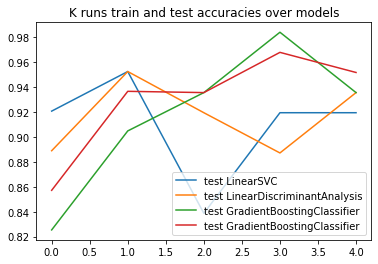

In [62]:
train_show = False
for i in range(len(models)):
    if train_show:
        plt.plot(range(len(avg_train[i])),avg_train[i], 
             label='train {}'.format(type(models[i]).__name__))
    plt.plot(range(len(avg_test[i])),avg_test[i], 
             label='test {}'.format(type(models[i]).__name__))

plt.title('K runs train and test accuracies over models')
plt.legend()
plt.show()

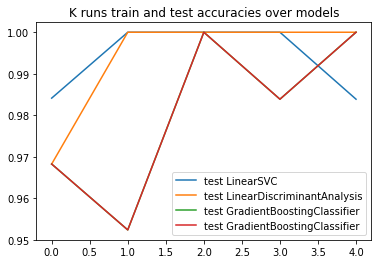

In [99]:
# with the modified one (connected components)
train_show = False
for i in range(len(models)):
    if train_show:
        plt.plot(range(len(avg_train[i])),avg_train[i], 
             label='train {}'.format(type(models[i]).__name__))
    plt.plot(range(len(avg_test[i])),avg_test[i], 
             label='test {}'.format(type(models[i]).__name__))

plt.title('K runs train and test accuracies over models')
plt.legend()
plt.show()

In [114]:
import pickle

with open('model_suit.pickle', 'wb') as handle:
    s = pickle.dump(lf, handle)
with open('model_suit.pickle', 'rb') as handle:
    clf = pickle.load(handle)

clf.score(X,y)

1.0